# Fudan RPML Assignment2: Deep Learning Meets News

![news](./news.png)

**Your name and Student ID: [李培基], [20307140044]**

Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.

In this assignment, you will build a **text classification** system which is a fundamental task in the field of Natural Language Processing (NLP). More precisely, you are given a news classification task, assigning given news texts to the categories to which they belong. Unlike traditional classification tasks, **we did not provide you with any labels for this assignment, and you need to find a way to construct labels for these articles**. 

For this assignment you can use commonly used deep learning frameworks like paddle and pytorch, and **should use at least one kind of deep neural network for this task**. **You can use pretrained word vectors like Glove, but not pretrained large models like BERT.**

# 1. Setup

In [22]:
# setup code
%load_ext autoreload
%autoreload 2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import jieba
import pandas as pd
import torch
args = {
    'learning_rate':0.0004, 
    'first_momentum':0.9,
    'second_momentum':0.999,
    'batch_size':32,
    'len_feature':300, # embedding_dim
    'hidden_size':50,
    'dropout':0.5,
    'iter_times':50,
    'num_class':4
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dataset_path = 'assignment2_news.pkl'

all_data = None
with open(dataset_path,'rb') as fin:
    all_data = pickle.load(fin)

print(all_data[10343])
print(all_data[78883])
# 明显，这是一个中文新闻标题数据集

什么企业适合开展融资租赁业务？你不看，真的吃大亏了！
你见过苗寨里待客的方式吗？网友调侃：这才是真正的不醉不归啊！


# 2. Exploratory Data Analysis (5 points)

数据集句子总数 83360
数据集字符最长/最短长度: 145 / 2
数据集中最长字符的句子:
 【定了！中日双方签署有关经贸合作协议】5月9日，在李克强总理和安倍晋三首相共同见证下，中国商务部钟山部长与日本经济产业大臣世耕弘成共同签署了《关于加强服务贸易合作的备忘录》，中国国家发展改革委、商务部与日本外务省、经济产业省共同签署了《关于中日第三方市场合作的备忘录》。详细内容，请戳大图↓
数据集中最短字符的句子:
 美国
数据集中句子字符长度平均值: 22.235280710172745
数据集中句子字符长度超过 50 的句子数目: 66 / 83360
因此结合句子长度分布图，我们有理由在后续处理时对句子长度进行截取


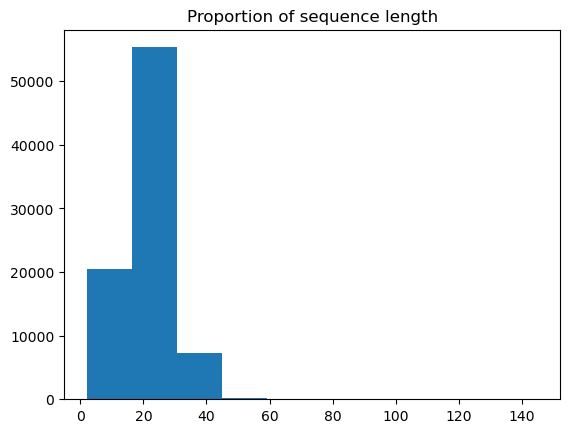

In [24]:
%matplotlib inline
print('数据集句子总数',len(all_data))
min_len = 9999
max_len = 0
id_1 = -1
id_2 = -1
len_list = []
for idx,sentence in enumerate(all_data,0):
    l = len(sentence)
    if l > max_len:
        max_len = l
        id_1 = idx
    if l < min_len:
        min_len = l
        id_2 = idx
    len_list.append(l)
print('数据集字符最长/最短长度:',max_len,'/',min_len)
print('数据集中最长字符的句子:\n',all_data[id_1])
print('数据集中最短字符的句子:\n',all_data[id_2])
print('数据集中句子字符长度平均值:',sum(len_list)/len(len_list))
print('数据集中句子字符长度超过 50 的句子数目:',sum(np.array(len_list) > 50),'/',len(all_data))
print('因此结合句子长度分布图，我们有理由在后续处理时对句子长度进行截取')
plt.title('Proportion of sequence length')
plt.hist(len_list)
plt.show()

In [50]:
# 尝试jieba分词效果
import jieba
seg_list = jieba.cut("【定了！中日双方签署有关经贸合作协议】5月9日，在李克强总理和安倍晋三首相共同见证下，中国商务部钟山部长与日本经济产业大臣世耕弘成共同签署了《关于加强服务贸易合作的备忘录》，中国国家发展改革委、商务部与日本外务省、经济产业省共同签署了《关于中日第三方市场合作的备忘录》。详细内容，请戳大图↓")  # 默认是精确模式
print(seg_list)
print(" ".join(seg_list))
seg_list = jieba.lcut("【定了！中日双方签署有关经贸合作协议】5月9日，在李克强总理和安倍晋三首相共同见证下，中国商务部钟山部长与日本经济产业大臣世耕弘成共同签署了《关于加强服务贸易合作的备忘录》，中国国家发展改革委、商务部与日本外务省、经济产业省共同签署了《关于中日第三方市场合作的备忘录》。详细内容，请戳大图↓")
print(seg_list) 

<generator object Tokenizer.cut at 0x7f5b1d37b2a0>
【 定 了 ！ 中日 双方 签署 有关 经贸合作 协议 】 5 月 9 日 ， 在 李克强 总理 和 安倍晋三 首相 共同 见证 下 ， 中国 商务部 钟山 部长 与 日本 经济 产业 大臣 世耕弘成 共同 签署 了 《 关于 加强 服务 贸易 合作 的 备忘录 》 ， 中国 国家 发展 改革 委 、 商务部 与 日本外务省 、 经济 产业省 共同 签署 了 《 关于 中日 第三方 市场 合作 的 备忘录 》 。 详细 内容 ， 请 戳 大图 ↓
['【', '定', '了', '！', '中日', '双方', '签署', '有关', '经贸合作', '协议', '】', '5', '月', '9', '日', '，', '在', '李克强', '总理', '和', '安倍晋三', '首相', '共同', '见证', '下', '，', '中国', '商务部', '钟山', '部长', '与', '日本', '经济', '产业', '大臣', '世耕弘成', '共同', '签署', '了', '《', '关于', '加强', '服务', '贸易', '合作', '的', '备忘录', '》', '，', '中国', '国家', '发展', '改革', '委', '、', '商务部', '与', '日本外务省', '、', '经济', '产业省', '共同', '签署', '了', '《', '关于', '中日', '第三方', '市场', '合作', '的', '备忘录', '》', '。', '详细', '内容', '，', '请', '戳', '大图', '↓']


# 3. Construct the Labels (40 points)

## 3.1 average_word_embedding + K-means聚类
1. 首先利用jieba分词，去除只有一个词的文本，并去除中文停用词，获得分词后的文本数据集
2. 之后使用预训练的word_vector标注每一个句子中的单词，然后对这些单词向量取平均，获得每个句子的sentence_embedding，最后再进行K-means聚类，将数据集中的句子无监督的进行分类。


In [21]:
# 加载预训练的word_embedding [365076,300]
# sgns.sogounews.bigram-char sgns.sogou.char
with open('sgns.sogou.char','rb') as f:
    lines = f.readlines()
    
trained_dict = dict()
n = len(lines)  # 为预训练文件总行数
embedding_dim = len(lines[1].split())-1
for i in range(1,n):
    # 因为第一行不是数据 共365076的词/字 每个被映射到300维空间
    line = lines[i].split()
    trained_dict[line[0].decode('utf-8')] = [float(line[j]) for j in range(1,embedding_dim+1)]

In [4]:
# 用jieba 进行中文分词
data = []
for sentence in all_data:
    seg_list = [w for w in jieba.cut(sentence) if len(w) > 1]
    if len(seg_list) > 1 and seg_list != '\r\t':
        data.append(seg_list)
#停用词加载
stopwords = pd.read_table('stopwords.txt',names = ['stopword'],quoting = 3)

df_content = pd.DataFrame({'data':data})
#去除停用词
def drop_stopwords(contents,stopwords):
    contents_clean = []
    all_words = []
    for line in contents:
        line_clean = []
        for word in line:
            if word in stopwords:
                continue
            line_clean.append(word)
            all_words.append(word)
        contents_clean.append(line_clean)
    return contents_clean,all_words

data = df_content.data.values.tolist()

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.918 seconds.
Prefix dict has been built successfully.


In [8]:
# 使用中文分词后 数据集句子的长度分析
print('数据集句子总数',len(data))
min_len = 9999
max_len = 0
id_1 = -1
id_2 = -1
len_list = []
for idx,sentence in enumerate(data,0):
    l = len(sentence)
    if l > max_len:
        max_len = l
        id_1 = idx
    if l < min_len:
        min_len = l
        id_2 = idx
    len_list.append(l)
print('数据集最长/最短长度:',max_len,'/',min_len)
print('数据集中最多词的句子:\n',data[id_1])
print('数据集中最少词的句子:\n',data[id_2])
print('数据集中词长度长度平均值:',sum(len_list)/len(len_list))
print('数据集中词数量超过 30 的句子数目:',sum(np.array(len_list) > 30),'/',len(data))

数据集句子总数 83175
数据集最长/最短长度: 48 / 2
数据集中最多词的句子:
 ['中日', '双方', '签署', '有关', '经贸合作', '协议', '李克强', '总理', '安倍晋三', '首相', '共同', '见证', '中国', '商务部', '钟山', '部长', '日本', '经济', '产业', '大臣', '世耕弘成', '共同', '签署', '关于', '加强', '服务', '贸易', '合作', '备忘录', '中国', '国家', '发展', '改革', '商务部', '日本外务省', '经济', '产业省', '共同', '签署', '关于', '中日', '第三方', '市场', '合作', '备忘录', '详细', '内容', '大图']
数据集中最少词的句子:
 ['都江堰', '景区']
数据集中词长度长度平均值: 7.518352870453862
数据集中词数量超过 30 的句子数目: 5 / 83175


In [9]:
import torch
class Embedding():
    def __init__(self,trained_dict,data,args) -> None:
        self.dict_words = {}    # 单词映射到自然数的字典
        self.sentence_matrix = []   # 数据集中句子的矩阵表示（每个词为一个自然数）
        self.embedding_matrix = [] # embedding矩阵，每个word_vector对应的下标id为相应的词
        self.trained_dict = trained_dict  # 预训练的词典：词与word_vector的对应
        self.embedding_dim = args['len_feature'] # embedding dim
        self.data = data # 分词后的数据集
        self.sentence_vector = [] # 数据集每个句子的向量表示(sentence embedding)
        self.labels = None
    
    def get_words(self):
        '''
        此函数的目标是建立单词与自然数的映射的词典,同时建立好embedding_weight矩阵,并不处理数据集
        '''
        self.embedding_matrix.append([0]*self.embedding_dim) # [PAD] id:0
        self.embedding_matrix.append([0]*self.embedding_dim) # [UNK] id:1
        self.dict_words['[PAD]'] = 0
        self.dict_words['[UNK]'] = 1
        for word in self.trained_dict.keys():
            if word not in self.dict_words:
                self.dict_words[word] = len(self.dict_words) + 2
                self.embedding_matrix.append(self.trained_dict[word])
        mean = torch.mean(torch.tensor(self.embedding_matrix))
        std = torch.std(torch.tensor(self.embedding_matrix))
        unknown_vec = torch.normal(mean,std,size = [1,self.embedding_dim]).reshape(-1)
        self.embedding_matrix[1] = unknown_vec.tolist()    # for [UNK]： Gaussian Sample 有的论文做法
    
    def get_id(self):
        '''
        这个函数目的是给数据集中的句子建立成矩阵，每个句子表示为一串id，对应着 embedding矩阵的 下标
        '''
        for sentence in self.data:
            item = []
            for word in sentence:
                if word not in self.dict_words:
                    item.append(self.dict_words['[UNK]'])
                else:
                    item.append(self.dict_words[word])
            self.sentence_matrix.append(item)
    
    def average_sen2vec(self):
        '''
        此函数的目标是做一个sentence_embedding,即sen2vec
        '''
        for sentence in self.sentence_matrix:
            sum_vec = np.array([0.0]*self.embedding_dim,dtype = 'float32')
            sentence_length = len(sentence)
            for idx in sentence:
                word_vec = np.array(self.embedding_matrix[idx],dtype = 'float32')
                sum_vec = sum_vec + word_vec
            self.sentence_vector.append( (sum_vec/sentence_length).tolist() )
            

/remote-home/pjli/anaconda3/envs/nlptorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
ebd = Embedding(trained_dict=trained_dict,data=data,args=args)
ebd.get_words()
ebd.get_id()

In [11]:
ebd.average_sen2vec()

In [12]:
m = ebd.sentence_vector


In [14]:
# 此部分仅是实验一下效果
from sklearn.cluster import KMeans
import numpy as np
X = np.array(m)
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
news_data = []
for idx,sentence in enumerate(data,0):
    item = [sentence] + [kmeans.labels_[idx]]
    news_data.append(item)

In [19]:
# 我们测试一下分类效果
print(len(news_data))
for i in range(200):
    s = news_data[i][1]
    if s == 0:
        print(news_data[i])

83175
[['经济学家', '吴敬琏', '为什么', '反对', '不惜代价', '发展', '芯片', '产业'], 0]
[['如何', '评价', '许鞍华', '导演', '电影', '为什么', '总能', '给人以', '触动'], 0]
[['规划', '公示', '苏州', '古城区', '变化'], 0]
[['放任', '台独', '叫嚣', '英文', '戳破', '现状'], 0]
[['方舟子', '象棋', '源自', '印度', '中国', '古代', '没有', '大象', '认为', '这种', '说法', '怎么样'], 0]
[['高考', '志愿', '影响', '未来'], 0]
[['2018', '航天', '领域', '发生', '哪些', '期待'], 0]
[['古希腊', '众神', '那点', '事儿'], 0]
[['缅甸', '人民', '云南', '瑞丽', '幸福生活'], 0]
[['为什么', '股东', '人数', '大幅', '减少', '筹码', '更为', '集中', '股票', '一直', '下跌'], 0]
[['郭德纲', '恩师', '侯耀文', '出身', '名门', '一生', '显赫', '死后', '四年', '得以', '入土为安'], 0]
[['农产品', '怎么', '才能', '赚大钱', '大家', '过来'], 0]
[['智能', '制造', '产业园', '落户', '高新区'], 0]
[['夏普', '推出', '机器人', '手机', '售价', '11000', '人民币', '功能齐全', '长得', '很萌'], 0]
[['2018', '巴西', '大豆', '产量', '历史', '纪录', '中国', '买家', '好消息'], 0]
[['月份', '巴中', '城区', '鲜菜', '价格', '降幅', '收窄'], 0]
[['广东', '哪个', '地方', '茶叶', '出名'], 0]
[['美国', '生活', '怎么', '公寓'], 0]
[['美丽', '乡村', '温州'], 0]
[['潜伏', '蒋介石', '身边', '女特工', '凭借', '特殊', '能力', '重用', '后来', '结局', 

In [18]:
print(kmeans.labels_[0:20])
print(data[0:20])


[0 2 1 1 0 0 0 0 1 0 2 0 0 1 1 0 0 1 0 0]
[['经济学家', '吴敬琏', '为什么', '反对', '不惜代价', '发展', '芯片', '产业'], ['颜值', '一双', '美腿', '甚至', '可以', '忽略', '颜值'], ['转自', '常德', '诗人', '再访', '桃花源', '再续', '心灵', '故乡', '故事'], ['虎牙', '拼杀', '四年', '游戏', '直播', '第一股', '真正', '挑战', '才刚', '开始'], ['如何', '评价', '许鞍华', '导演', '电影', '为什么', '总能', '给人以', '触动'], ['规划', '公示', '苏州', '古城区', '变化'], ['放任', '台独', '叫嚣', '英文', '戳破', '现状'], ['方舟子', '象棋', '源自', '印度', '中国', '古代', '没有', '大象', '认为', '这种', '说法', '怎么样'], ['徐小平', '投资', '100%', '看人', '创业者', '见面', '马上', '给钱'], ['高考', '志愿', '影响', '未来'], ['小米', 'mix2', 'vivox21', 'oppor15', '哪个', '性价比'], ['2018', '航天', '领域', '发生', '哪些', '期待'], ['古希腊', '众神', '那点', '事儿'], ['上联', '一生', '二生', '三生', '万物', '物物', '生辉', '怎么', '下联'], ['猪八戒', '为啥', '真武大帝', '不怕', '自吹', '不敢'], ['缅甸', '人民', '云南', '瑞丽', '幸福生活'], ['为什么', '股东', '人数', '大幅', '减少', '筹码', '更为', '集中', '股票', '一直', '下跌'], ['现金', '农村', '中小学', '教师', '三十年', '教龄', '荣誉证书', '你会选', '一个'], ['郭德纲', '恩师', '侯耀文', '出身', '名门', '一生', '显赫', '死后', '四年', '得以', '入土为安'], 

## 3.2 LDA主题模型
LDA 主题模型又称隐性狄利克雷模型，是由2003的一篇论文 Latent Dirichlet Allocation提出，作者是 Blei D M, Ng A Y, Jordan M I，其中就有吴恩达老师。是一种无监督的用于将文档分类的机器学习方法，能够为每个主题生成关键词权重，同时可以给出一篇文档属于各个主题的的概率。

1. 利用jieba分词，去除只有一个词的文本，并去除中文停用词，获得分词后的文本数据集
2. 利用LDA模型将文本分类，因为得到主题都具有可解释性(具有关键词)，我们直接取每个文本具有最大概率的主题作为该条文本的标签，而不再进行聚类方法。

In [30]:
class Embedding():
    def __init__(self,trained_dict,data,args) -> None:
        self.dict_words = {}    # 单词映射到自然数的字典
        self.sentence_matrix = []   # 数据集中句子的矩阵表示（每个词为一个自然数）
        self.embedding_matrix = [] # embedding矩阵，每个word_vector对应的下标id为相应的词
        self.trained_dict = trained_dict  # 预训练的词典：词与word_vector的对应
        self.embedding_dim = args['len_feature'] # embedding dim
        self.data = data # 分词后的数据集
        self.sentence_vector = [] # 数据集每个句子的向量表示(sentence embedding)
        self.labels = None
    
    def get_words(self):
        '''
        此函数的目标是建立单词与自然数的映射的词典,同时建立好embedding_weight矩阵,并不处理数据集
        '''
        self.embedding_matrix.append([0]*self.embedding_dim) # [PAD] id:0
        self.embedding_matrix.append([0]*self.embedding_dim) # [UNK] id:1
        self.dict_words['[PAD]'] = 0
        self.dict_words['[UNK]'] = 1
        for word in self.trained_dict.keys():
            if word not in self.dict_words:
                self.dict_words[word] = len(self.dict_words) + 2
                self.embedding_matrix.append(self.trained_dict[word])
        mean = torch.mean(torch.tensor(self.embedding_matrix))
        std = torch.std(torch.tensor(self.embedding_matrix))
        unknown_vec = torch.normal(mean,std,size = [1,self.embedding_dim]).reshape(-1)
        self.embedding_matrix[1] = unknown_vec.tolist()    # for [UNK]： Gaussian Sample 有的论文做法
    
    def get_id(self):
        '''
        这个函数目的是给数据集中的句子建立成矩阵，每个句子表示为一串id，对应着 embedding矩阵的 下标
        '''
        for sentence in self.data:
            item = []
            for word in sentence:
                if word not in self.dict_words:
                    item.append(self.dict_words['[UNK]'])
                else:
                    item.append(self.dict_words[word])
            self.sentence_matrix.append(item)
    
    def average_sen2vec(self):
        '''
        此函数的目标是做一个sentence_embedding,即sen2vec
        '''
        for sentence in self.sentence_matrix:
            sum_vec = np.array([0.0]*self.embedding_dim,dtype = 'float32')
            sentence_length = len(sentence)
            for idx in sentence:
                word_vec = np.array(self.embedding_matrix[idx],dtype = 'float32')
                sum_vec = sum_vec + word_vec
            self.sentence_vector.append( (sum_vec/sentence_length).tolist() )
    
    def get_labels(self,labels):
        self.labels != labels
        if len(labels) != len(self.data):
            raise Exception('标签数量与数据集数量不相符')

In [24]:
with open('sgns.sogou.char','rb') as f:
    lines = f.readlines()
    
trained_dict = dict()
n = len(lines)  # 为预训练文件总行数
embedding_dim = len(lines[1].split())-1

for i in range(1,n):
    # 因为第一行不是数据 共365076的词/字 每个被映射到300维空间
    line = lines[i].split()
    trained_dict[line[0].decode('utf-8')] = [float(line[j]) for j in range(1,embedding_dim+1)]
dataset_path = 'assignment2_news.pkl'

all_data = None
with open(dataset_path,'rb') as fin:
    all_data = pickle.load(fin)
content = all_data

In [26]:
#分词
content_S = []
for line in content:
    current_segment = [w for w in jieba.cut(line) if len(w) > 1] # 分词
    if len(current_segment) > 1 and current_segment != '\r\t':
        content_S.append(current_segment)
#分词结果转为DataFrame
df_content = pd.DataFrame({'content_S':content_S})

#停用词加载
stopwords = pd.read_table('stopwords.txt',names = ['stopword'],quoting = 3)

#去除停用词
def drop_stopwords(contents,stopwords):
    contents_clean = []
    all_words = []
    for line in contents:
        line_clean = []
        for word in line:
            if word in stopwords:
                continue
            line_clean.append(word)
            all_words.append(word)
        contents_clean.append(line_clean)
    return contents_clean,all_words

contents = df_content.content_S.values.tolist()
stopwords = stopwords.stopword.values.tolist()
#contents_clean存储的是一个文本处理结果一个数组，all_words是将所有文本处理结果存储为1个数组
contents_clean,all_words = drop_stopwords(contents,stopwords)

#处理后的结果转化为DataFrame
df_content = pd.DataFrame({'contents_clean':contents_clean})#文本处理结果
df_all_words = pd.DataFrame({'all_words':all_words})#语料词典

#统计语料词典中的词出现频率
words_count = df_all_words.groupby(by=['all_words'])['all_words'].agg([('count',np.size)])
words_count = words_count.reset_index().sort_values(by=['count'],ascending = False)#降序


from gensim import corpora,models,similarities
import gensim

dictionary = corpora.Dictionary(contents_clean)
corpus = [dictionary.doc2bow(sentence) for sentence in contents_clean]
lda = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary,num_topics=3,random_state=1)

labels = []

print(lda.print_topics(num_topics=3,num_words=10))
#预测文本的主题
for e, values in enumerate(lda.inference(corpus)[0]):
    # print(contents[e])
    max_value = -1
    label = -1
    for ee, value in enumerate(values):
        # print('\t主题%d推断值%.2f' % (ee, value))
        if value > max_value:
            max_value = value
            label = int(ee)
    labels.append(label)


[(0, '0.006*"上联" + 0.006*"下联" + 0.005*"手机" + 0.003*"看待" + 0.003*"王者" + 0.003*"荣耀" + 0.003*"游戏" + 0.003*"小米" + 0.003*"上市" + 0.003*"英雄"'), (1, '0.006*"网友" + 0.006*"农村" + 0.004*"知道" + 0.003*"孩子" + 0.003*"没有" + 0.003*"真的" + 0.003*"故事" + 0.003*"生活" + 0.003*"活动" + 0.002*"需要"'), (2, '0.019*"中国" + 0.012*"美国" + 0.007*"世界" + 0.005*"现在" + 0.005*"2018" + 0.004*"日本" + 0.004*"国家" + 0.004*"俄罗斯" + 0.003*"发展" + 0.003*"伊朗"')]


In [33]:
# 测试一下分类效果
# 分三类： 文娱看点 社会民生 国际时事
for i in range(200):
    if labels[i] == 2:
        print(contents[i])

['经济学家', '吴敬琏', '为什么', '反对', '不惜代价', '发展', '芯片', '产业']
['转自', '常德', '诗人', '再访', '桃花源', '再续', '心灵', '故乡', '故事']
['放任', '台独', '叫嚣', '英文', '戳破', '现状']
['2018', '航天', '领域', '发生', '哪些', '期待']
['缅甸', '人民', '云南', '瑞丽', '幸福生活']
['为什么', '股东', '人数', '大幅', '减少', '筹码', '更为', '集中', '股票', '一直', '下跌']
['农产品', '怎么', '才能', '赚大钱', '大家', '过来']
['2018', '巴西', '大豆', '产量', '历史', '纪录', '中国', '买家', '好消息']
['伊拉克', '战争', '十二张', '照片', '战争', '面前', '任何人', '渺小']
['一年级', '下册', '语文', '考试', '复习', '重点', '什么']
['民宿', '发展', '乡村', '旅游业', '发展', '必要', '联系']
['最具', '特色', '十大', '古村落', '中国', '才能', '看到', '绝无仅有']
['如果', '日本', '国土', '滑向', '海沟', '沉没', '要求', '中国', '人民', '收留', '作为', '中国', '接受', '日本']
['嘴仗', '结束', '伊朗', '局势', '升级', '中东', '热战', '开始', '美国', '为何', '积极', '点赞']
['磷酸', '价格', '大幅', '下跌', '相关', '上市公司', '承压', '明显', '影响']
['国内', '四款', '主要', '牵引车', '模型', '简单', '对比']
['魔鬼', '任用', '氨水', '女友', '双眼', '兜风', '痛久点']
['巴厘岛', '旅游', '是否', '见到']
['军事', '美国', '海军', '最新型', '高速', '双体船', '海上', '测试']
['为什么', '歌曲', '日语', '填词', '容易']
['上海', '孟买'

In [34]:
# 实例化Embedding类，并且为文本打上标签
ebd = Embedding(trained_dict=trained_dict,data=contents,args=args)
ebd.get_words()
ebd.get_id()
ebd.get_labels(labels)

## 3.3 对比与总结
我们尝试了两种无监督分类方法，虽然两种分类都存在一些文本被不正确的归为一类，但考虑到完全无监督没有经过训练的情况下，两种方法都展现了一定的效果。最终我们认为LDA模型更具有可解释性，且分类效果更好一些。因此我们最后采取LDA模型为文本建立标签

# 4. News Classification (50 points)

# 5. Conclusion (5 points)

# Reference
List your references here.

1. https://blog.csdn.net/kobeyu652453/article/details/107559519
2. https://github.com/blei-lab/lda-c
3. https://blog.csdn.net/v_july_v/article/details/41209515#t13